In [ ]:
# validation of the model using simulation data

import torch
import numpy as np
from plot_ult import *
from stable_baselines3 import TD3
from scipy.ndimage.filters import gaussian_filter


In [16]:
# load agent and task --------------------------------------------------------
env=ffacc_real.FireFlyPaper(arg)
env.episode_len=50
env.debug=1
env.terminal_vel=0.2
phi=torch.tensor([[1],
            [pi/2],
            [0.001],
            [0.001],
            [0.001],
            [0.001],
            [0.13],
            [0.001],
            [0.001],
            [0.001],
            [0.001],
    ])
agent_=TD3.load('trained_agent/paper.zip')
agent=agent_.actor.mu.cpu()

inv_file='inv0325_0325simulationpert'
datafile='0325simulationpert'

with open(Path(datapath/'simulation/inv')/inv_file,'rb') as f:
    log=pickle.load(f)
with open(Path(datapath/'simulation')/datafile, 'rb') as f:
    states, actions, tasks, groundtruth = pickle.load(f)


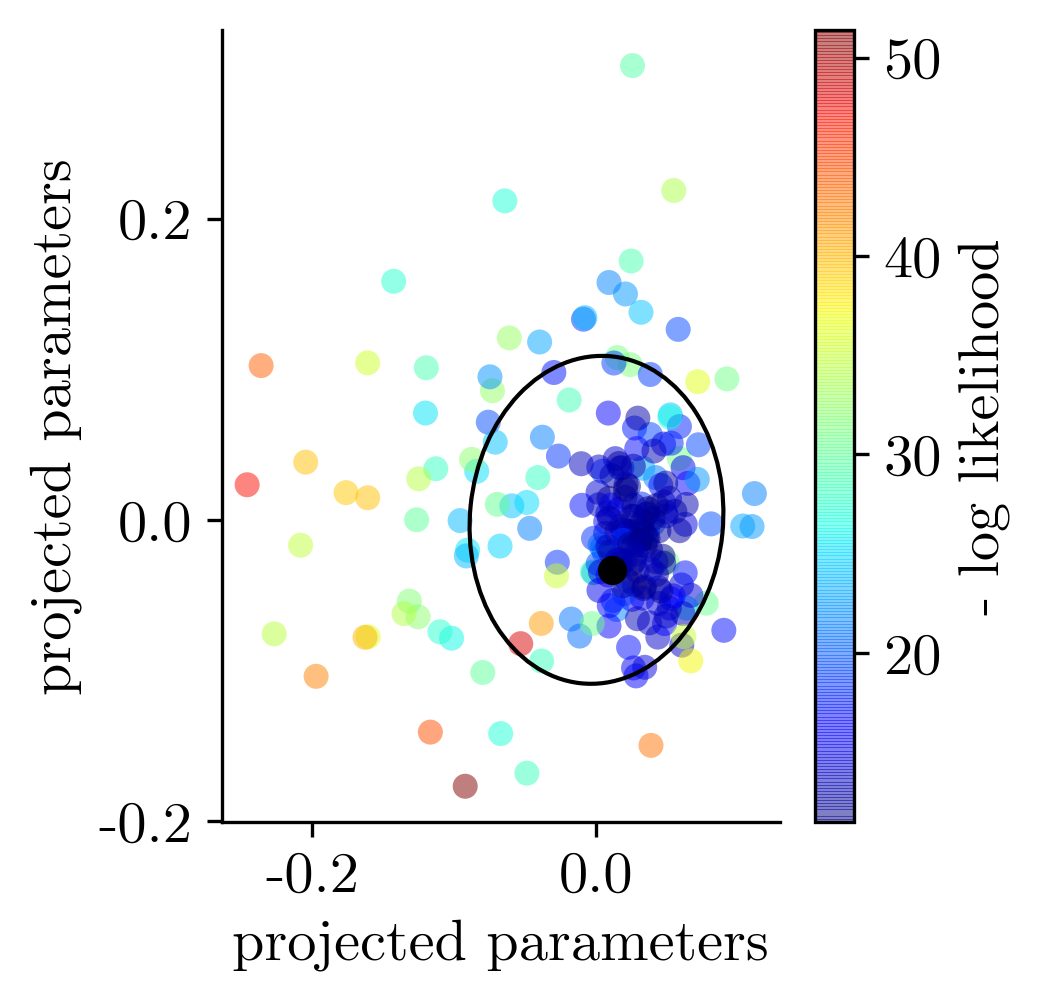

In [18]:

# project pca ---------------------------------------------------
res=[l[2] for l in log]
allsamples=[]
alltheta=[]
loglls=[]
for r in res:
    for point in r:
        alltheta.append(torch.tensor(point[0]))
        loglls.append(torch.tensor(point[1]))
        allsamples.append([point[1],point[0]])
alltheta=torch.stack(alltheta)
logllsall=torch.tensor(loglls).flatten()
allsamples.sort(key=lambda x: x[0])

projectedparam=torch.pca_lowrank(torch.tensor(alltheta),2)
transition=projectedparam[2] # the V
projectedparamall=projectedparam[0] # the U

allthetamu=torch.mean(alltheta, axis=0)
centeralltheta=alltheta-allthetamu
u,s,v=torch.pca_lowrank(torch.tensor(centeralltheta),2)

mu=torch.mean(projectedparamall,axis=0)
aroundsolution=allsamples[:len(allsamples)//2]
aroundsolution.sort(key=lambda x: x[0])
alltheta=np.vstack([x[1] for x in aroundsolution])
alltheta[:,5:]=groundtruth[5:,0]
loglls=[x[0] for x in aroundsolution]
pccov=transition.T@torch.tensor(np.cov(alltheta.T)).float()@transition

with initiate_plot(3, 3.5, 300) as fig, warnings.catch_warnings():
    warnings.simplefilter('ignore')
    ax = fig.add_subplot(111)
    plot_cov_ellipse(pccov, mu, alpha=1,nstd=1,ax=ax, edgecolor='k')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    scatters = ax.scatter(projectedparamall[:,0], projectedparamall[:,1], c=(logllsall),alpha=0.5,edgecolors='None', cmap='jet')
    ax.set_xlabel('projected parameters')
    ax.set_ylabel('projected parameters')
    c = fig.colorbar(scatters, ax=ax)
    ax.locator_params(nbins=3, axis='y')
    ax.locator_params(nbins=3, axis='x')
    # c.clim(min(np.log(loglls)), max(np.log(loglls))) 
    c.set_label('- log likelihood')
    # c.set_ticks([min((loglls)),max((loglls))])
    c.ax.locator_params(nbins=4)
    # plot ground truth for simulation
    try:
        groundtruthpc=(groundtruth.view(-1)-allthetamu)@np.array(v)@np.linalg.inv(np.diag(s))
        ax.scatter(groundtruthpc[0],groundtruthpc[1],color='k')
    except NameError:
        pass

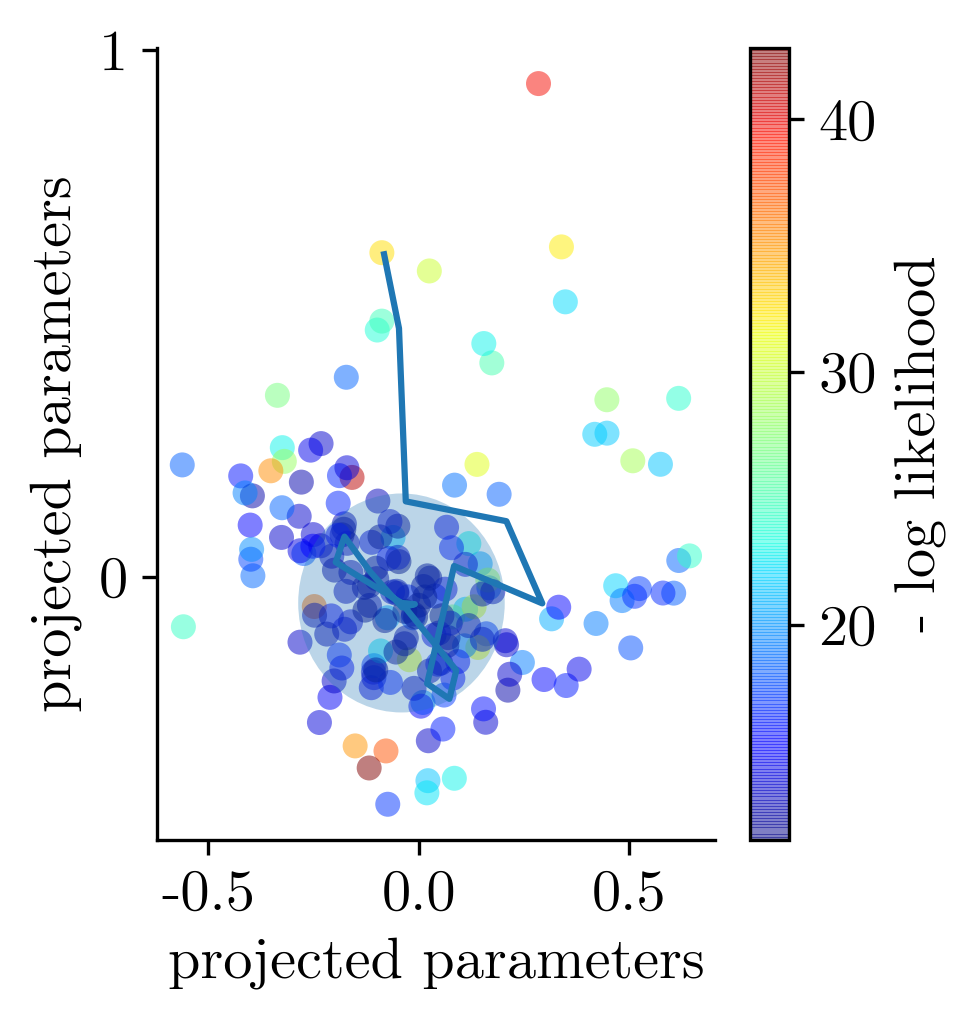

In [19]:
res=[l[2] for l in log]
allsamples=[]
alltheta=[]
alltheta.append(groundtruth.view(-1))
loglls=[]
for r in res:
    for point in r:
        alltheta.append(torch.tensor(point[0]))
        loglls.append(torch.tensor(point[1]))
        allsamples.append([point[1],point[0]])
alltheta=torch.stack(alltheta)
logllsall=torch.tensor(loglls).flatten()
allsamples.sort(key=lambda x: x[0])
allthetameans=np.array([l[0]._mean for l in log])
alltheta=alltheta[50:]
logllsall=logllsall[50:]
mu=np.mean(np.asfarray(alltheta),0).astype('float32')
score, evectors, evals = pca(np.asfarray(alltheta))
x=score[1:,0] # pc1
y=score[1:,1] # pc2
z=logllsall

finalcov=log[-1][0]._C
realfinalcov=np.cov(np.array([l[0] for l in log[-1][2]]).T)

finaltheta=log[-1][0]._mean
pcfinaltheta=((finaltheta.reshape(-1)-mu)@evectors).astype('float32')
finalcovpc=(evectors.T@finalcov@evectors).astype('float32')
realfinalcovpc=(evectors.T@realfinalcov@evectors).astype('float32')
pccov=evectors.T@(np.cov(alltheta.T))@evectors
allthetameanspc=((allthetameans-mu)@evectors).astype('float32')
xlow,xhigh=pcfinaltheta[0]-0.3,pcfinaltheta[0]+0.3
ylow,yhigh=pcfinaltheta[1]-0.3,pcfinaltheta[1]+0.3

npixel=7
xrange=np.linspace(-0.1, 0.3,npixel)
yrange=np.linspace(-0.2,0.2,npixel)

with initiate_plot(3, 3.5, 300) as fig, warnings.catch_warnings():
    warnings.simplefilter('ignore')
    ax = fig.add_subplot(111)
    plot_cov_ellipse(pccov[:2,:2], pcfinaltheta[:2], alpha=0.3,nstd=1,ax=ax)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    s = ax.scatter(x,y, c=z,alpha=0.5,edgecolors='None', cmap='jet')
    ax.set_xlabel('projected parameters')
    ax.set_ylabel('projected parameters')
    c = fig.colorbar(s, ax=ax)
    ax.locator_params(nbins=3, axis='y')
    ax.locator_params(nbins=3, axis='x')
    # c.clim(min(np.log(loglls)), max(np.log(loglls))) 
    c.set_label('- log likelihood')
    # c.set_ticks([min((loglls)),max((loglls))])
    c.ax.locator_params(nbins=4)
    ax.plot(allthetameanspc[:,0],allthetameanspc[:,1])


    groundtruthpc=(groundtruth.view(-1)-allthetamu)@np.array(evectors)@np.linalg.inv(np.diag(evals))



In [20]:
# compute pca background ----------------------------------------------

# # single process
# def getlogll(x):
#     with torch.no_grad():
#         return  monkeyloss_(agent, actions, tasks, phi, torch.tensor(x).t(), env, action_var=0.01,num_iteration=1, states=states, samples=5,gpu=False).item()

# background_data=np.zeros((npixel,npixel))
# for i,u in enumerate(xrange):
#     for j,v in enumerate(yrange):
#         score=np.array([u,v])
#         reconstructed_theta=score@evectors.transpose()[:2,:]+mu
#         reconstructed_theta=reconstructed_theta.clip(1e-4,999)
#         background_data[i,j]=getlogll(reconstructed_theta.reshape(1,-1).astype('float32'))

# use ray
# note='lowres0325'
# import ray
# from notification import notify
# ray.init(log_to_driver=False,ignore_reinit_error=True)
# @ray.remote
# def getlogll(x):
#     x=torch.tensor(x)
#     if torch.any(x>2) or torch.any(x<=0):
#         return None
#     with torch.no_grad():
#         return  monkeyloss_(agent, actions, tasks, phi, torch.tensor(x).view(-1,1), env, action_var=0.01,num_iteration=1, states=states, samples=5,gpu=False).item()

# reconstructed_thetas=[]
# for i,u in enumerate(xrange):
#     for j,v in enumerate(yrange):
#         score=np.array([u,v])
#         reconstructed_theta=score@evectors.transpose()[:2,:]+mu
#         reconstructed_theta=reconstructed_theta.clip(1e-4,999)
#         reconstructed_thetas.append(reconstructed_theta)
        
# Z=ray.get([getlogll.remote(each.reshape(1,-1).astype('float32')) for each in reconstructed_thetas])
# background_data=np.array(Z).reshape(npixel,npixel)
# notify('background done')

# with open(datapath/'simulation/bg/{}_{}'.format(inv_file,note), 'wb+') as f:
#         pickle.dump((npixel,Z), f, protocol=pickle.HIGHEST_PROTOCOL)



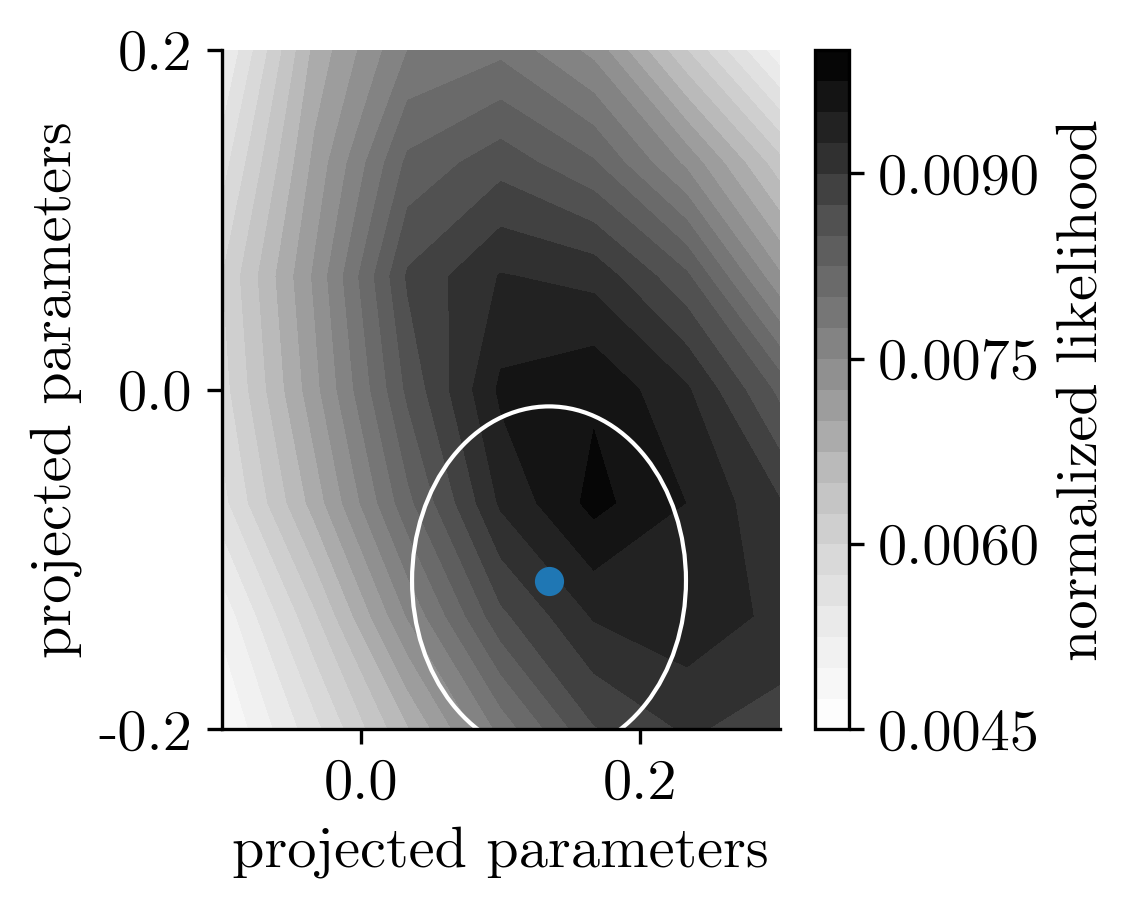

In [24]:
# visualize from pre computed results
with open(Path(datapath/'simulation/inv')/inv_file,'rb') as f:
    log=pickle.load(f)[:6]
with open(Path(datapath/'simulation')/datafile, 'rb') as f:
    states, actions, tasks, groundtruth = pickle.load(f)
res=[l[2] for l in log]
allsamples=[]
alltheta=[]
alltheta.append(groundtruth.view(-1))
loglls=[]
for r in res:
    for point in r:
        alltheta.append(torch.tensor(point[0]))
        loglls.append(torch.tensor(point[1]))
        allsamples.append([point[1],point[0]])
alltheta=torch.stack(alltheta)
logllsall=torch.tensor(loglls).flatten()
allsamples.sort(key=lambda x: x[0])
allthetameans=np.array([l[0]._mean for l in log])
alltheta=alltheta[50:]
logllsall=logllsall[50:]
mu=np.mean(np.asfarray(alltheta),0).astype('float32')
score, evectors, evals = pca(np.asfarray(alltheta))
x=score[1:,0] # pc1
y=score[1:,1] # pc2
z=logllsall

finalcov=log[-1][0]._C
realfinalcov=np.cov(np.array([l[0] for l in log[-1][2]]).T)

finaltheta=log[-1][0]._mean
pcfinaltheta=((finaltheta.reshape(-1)-mu)@evectors).astype('float32')
finalcovpc=(evectors.T@finalcov@evectors).astype('float32')
realfinalcovpc=(evectors.T@realfinalcov@evectors).astype('float32')
pccov=evectors.T@(np.cov(alltheta.T))@evectors
allthetameanspc=((allthetameans-mu)@evectors).astype('float32')
xlow,xhigh=pcfinaltheta[0]-0.3,pcfinaltheta[0]+0.3
ylow,yhigh=pcfinaltheta[1]-0.3,pcfinaltheta[1]+0.3

note='lowres0325'
with open(datapath/'simulation/bg/{}_{}'.format(inv_file,note), 'rb+') as f:
        npixel, Z=pickle.load(f)

formatedZ = np.array(Z).reshape(int(len(Z)**0.5),-1)
X,Y=np.meshgrid(xrange,yrange)
sigma = 0.5
xmin=0
ymin=0
X, Y, formatedZ = X[ymin:,xmin:],Y[ymin:,xmin:],gaussian_filter(-formatedZ[ymin:,xmin:], sigma)
formatedZ=np.exp(formatedZ)


with initiate_plot(3, 3, 300) as fig, warnings.catch_warnings():
    warnings.simplefilter('ignore')
    ax = fig.add_subplot(111)
    pccov[1,1],pccov[0,0]=pccov[0,0],pccov[1,1]
    pcfinaltheta[0],pcfinaltheta[1]=pcfinaltheta[1],pcfinaltheta[0]
    plot_cov_ellipse(pccov[:2,:2]*0.1, pcfinaltheta[:2], alpha=1,nstd=1,ax=ax, edgecolor=[1,1,1])
    im=ax.contourf(X, Y, formatedZ ,cmap='Greys',levels=20)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel('projected parameters')
    ax.set_ylabel('projected parameters')
    c = fig.colorbar(im, ax=ax)
    ax.locator_params(nbins=3, axis='y')
    ax.locator_params(nbins=3, axis='x')
    c.set_label('normalized likelihood')
    c.ax.locator_params(nbins=4)
    ax.scatter(pcfinaltheta[0], pcfinaltheta[1])
    ax.set_xlim(xrange[0], xrange[-1])
    ax.set_ylim(yrange[0], yrange[-1])